# 1. Machine Lerning aplicada à predição de Câncer de Pele

## 1.1 Introdução do problema

O problema necessita de aprendizagem supervisionada. É uma atividade de classificação. 

Batch Learning ou online Learning? 

Serão testados diferentes algoritmos supervisionados. A medida de desempenho utilizada será a acurácia, especificidades e sensibilidade (matriz de confusão).

## 1.2 Get Data



Informar a descrição dessas variáveis.

In [3]:
import pandas as pd

# read the dataset to a Pandas' dataframe
data = pd.read_csv("DadosGeral.txt", sep='\t')

# data shape
print(data.shape)
data.head()

(1200, 11)


,symmetry_x,symmetry_y,diameter,variance_r,variance_g,variance_b,average_r,average_g,average_b,blue-whitish_veil,clinical_diagnosis
0,806,456,226,297.628,615.890,1218.480,55.4818,84.9337,145.976,4,Atypical
1,45,159,144,355.300,406.200,545.299,94.5793,98.8138,139.898,146,Common
2,998,670,184,478.496,638.963,1189.560,84.0958,90.7283,134.997,35,Atypical
3,884,934,192,388.811,307.433,556.579,94.9663,123.3360,179.045,321,Atypical
4,377,93,148,975.527,644.466,485.322,111.4910,148.6690,201.290,0,Atypical


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
symmetry_x            1200 non-null int64
symmetry_y            1200 non-null int64
diameter              1200 non-null int64
variance_r            1200 non-null float64
variance_g            1200 non-null float64
variance_b            1200 non-null float64
average_r             1200 non-null float64
average_g             1200 non-null float64
average_b             1200 non-null float64
blue-whitish_veil     1200 non-null int64
clinical_diagnosis    1200 non-null object
dtypes: float64(6), int64(4), object(1)
memory usage: 103.2+ KB


In [5]:
# Quantidade de dados por tipo de diagnóstico

data.clinical_diagnosis.value_counts()

Common      480
Atypical    480
Melanoma    240
Name: clinical_diagnosis, dtype: int64

In [6]:
data.describe()

,symmetry_x,symmetry_y,diameter,variance_r,variance_g,variance_b,average_r,average_g,average_b,blue-whitish_veil
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.0000
mean,739.061667,712.573333,242.875000,562.086956,698.106881,941.940743,78.540319,108.332405,167.811958,926.8550
std,1295.399994,1304.198636,89.821012,316.370230,373.275379,638.726257,24.221507,23.918657,36.356811,3348.7665
min,0.000000,0.000000,72.000000,92.438800,112.714000,42.723800,29.297800,54.822600,79.469900,0.0000
25%,210.000000,211.000000,168.000000,340.000250,414.872500,484.836750,59.986975,92.602125,139.898000,0.0000
50%,445.000000,432.000000,226.000000,491.768500,632.463500,787.318000,75.166550,107.009000,171.521000,0.0000
75%,813.250000,780.500000,306.500000,697.559000,901.512500,1232.220000,91.490175,125.227750,194.552750,36.0000
max,17062.000000,17062.000000,448.000000,1630.380000,2025.510000,3657.290000,149.557000,164.618000,246.271000,29395.0000


### 3 1.2.1 Discovery and visualize the Data to Gain Insight


Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the **corr()** method:

In [7]:
corr_matrix = data.corr()
corr_matrix["diameter"].\
  sort_values(ascending=False)

diameter             1.000000
blue-whitish_veil    0.372143
variance_r           0.268999
average_r            0.263263
symmetry_x           0.257008
variance_b           0.255310
symmetry_y           0.236157
variance_g           0.200497
average_g           -0.065255
average_b           -0.152442
Name: diameter, dtype: float64

## 1.3 Clean, Prepare & Manipulate Data


the values in the maximum_nights and number_of_reviews columns span much larger ranges. For example, the maximum_nights column has values as low as 27 and high as 1125, in the first few rows itself. If we use these 2 columns as part of a k-nearest neighbors model, these attributes could end up having an outsized effect on the distance calculations because of the largeness of the values. To prevent any single column from having too much of an impact on the distance, we can normalize all of the columns to have a mean of 0 and a standard deviation of 1.

Normalizing the values in each columns to the [standard normal distribution](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution) (mean of 0, standard deviation of 1) preserves the distribution of the values in each column while aligning the scales. To normalize the values in a column to the standard normal distribution, you need to:

- from each value, subtract the mean of the column
- divide each value by the standard deviation of the column

In [8]:
data_aux = data.drop('clinical_diagnosis', axis=1)
data_aux.describe()

,symmetry_x,symmetry_y,diameter,variance_r,variance_g,variance_b,average_r,average_g,average_b,blue-whitish_veil
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.0000
mean,739.061667,712.573333,242.875000,562.086956,698.106881,941.940743,78.540319,108.332405,167.811958,926.8550
std,1295.399994,1304.198636,89.821012,316.370230,373.275379,638.726257,24.221507,23.918657,36.356811,3348.7665
min,0.000000,0.000000,72.000000,92.438800,112.714000,42.723800,29.297800,54.822600,79.469900,0.0000
25%,210.000000,211.000000,168.000000,340.000250,414.872500,484.836750,59.986975,92.602125,139.898000,0.0000
50%,445.000000,432.000000,226.000000,491.768500,632.463500,787.318000,75.166550,107.009000,171.521000,0.0000
75%,813.250000,780.500000,306.500000,697.559000,901.512500,1232.220000,91.490175,125.227750,194.552750,36.0000
max,17062.000000,17062.000000,448.000000,1630.380000,2025.510000,3657.290000,149.557000,164.618000,246.271000,29395.0000


In [9]:
from sklearn.preprocessing import StandardScaler

# apply z-score (mean=0, std=1)
normalized = pd.DataFrame(StandardScaler().fit_transform(data_aux),
                            columns=data_aux.columns,
                            index=data_aux.index)
normalized.describe()

,symmetry_x,symmetry_y,diameter,variance_r,variance_g,variance_b,average_r,average_g,average_b,blue-whitish_veil
count,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03
mean,5.592748e-17,-3.663736e-17,-3.404684e-17,-3.178939e-16,1.421085e-16,-1.200891e-16,1.326717e-16,-3.389881e-16,-2.038878e-17,-3.888094e-16
std,1.000417e+00,1.000417e+00,1.000417e+00,1.000417e+00,1.000417e+00,1.000417e+00,1.000417e+00,1.000417e+00,1.000417e+00,1.000417e+00
min,-5.707656e-01,-5.465965e-01,-1.903188e+00,-1.485108e+00,-1.568914e+00,-1.408415e+00,-2.033856e+00,-2.238090e+00,-2.430876e+00,-2.768904e-01
25%,-4.085860e-01,-3.847439e-01,-8.339498e-01,-7.022763e-01,-7.590977e-01,-7.159477e-01,-7.663057e-01,-6.579315e-01,-7.680981e-01,-2.768904e-01
50%,-2.270992e-01,-2.152205e-01,-1.879520e-01,-2.223590e-01,-1.759311e-01,-2.421808e-01,-1.393462e-01,-5.535248e-02,1.020603e-01,-2.768904e-01
75%,5.729448e-02,5.210478e-02,7.086485e-01,4.283858e-01,5.451483e-01,4.546553e-01,5.348658e-01,7.066613e-01,7.358165e-01,-2.661357e-01
max,1.260595e+01,1.254122e+01,2.284661e+00,3.378126e+00,3.557579e+00,4.252966e+00,2.933190e+00,2.354190e+00,2.158928e+00,8.504628e+00


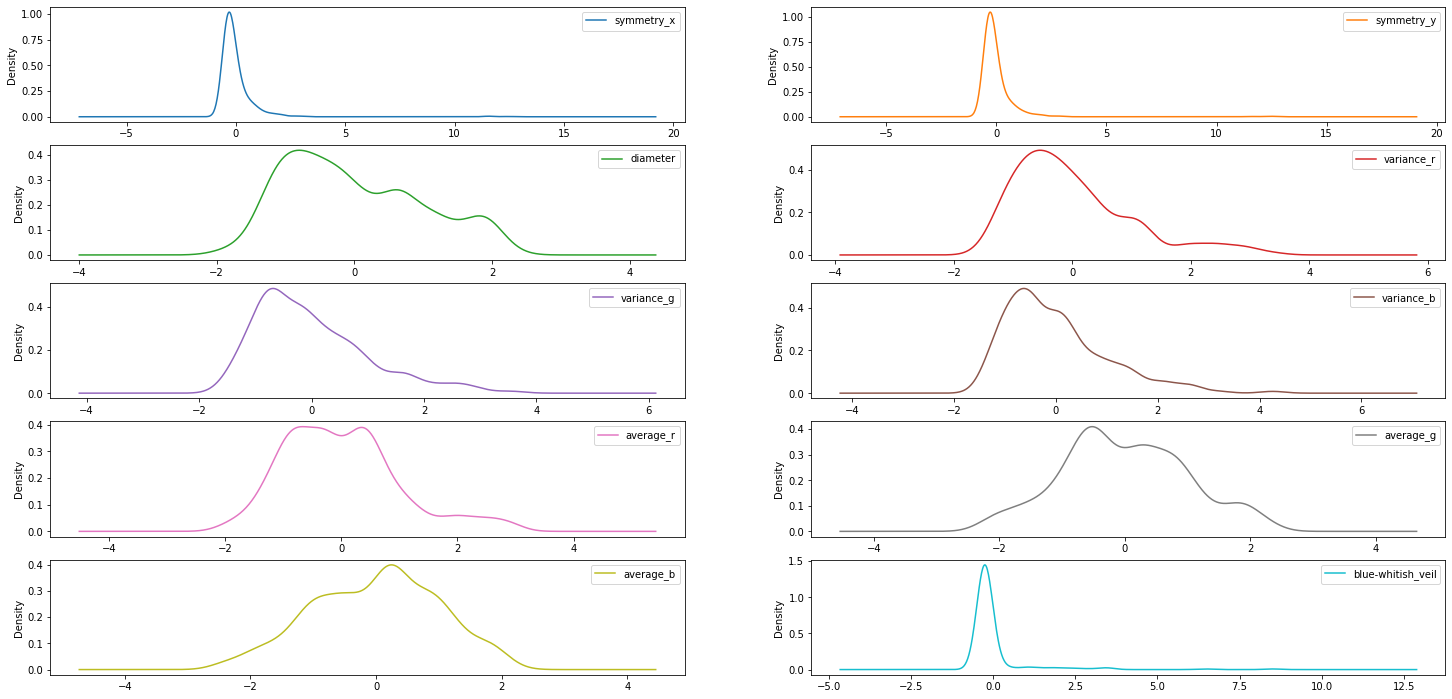

In [10]:
# Exploratory Data Analysis
# Identfy the KDE shape for all columns (gaussian distribution) after outlier elimination
import matplotlib.pyplot as plt
normalized.plot(kind='density',
                        layout=(10,2),
                        subplots=True,
                        figsize=(25,25),
                        sharex=False)
plt.show()

In [11]:
# remove outliers
normalized_outliers = normalized[(normalized < 2.698).all(axis=1)
               & (normalized > -2.698).all(axis=1)]
normalized_outliers.describe()

,symmetry_x,symmetry_y,diameter,variance_r,variance_g,variance_b,average_r,average_g,average_b,blue-whitish_veil
count,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000
mean,-0.093126,-0.091531,-0.082984,-0.154385,-0.149879,-0.124048,-0.111854,-0.030510,-0.005057,-0.149459
std,0.482116,0.458778,0.963013,0.801477,0.831842,0.865034,0.882801,0.981579,0.990497,0.451526
min,-0.570766,-0.546597,-1.903188,-1.485108,-1.568914,-1.408415,-2.033856,-2.238090,-2.430876,-0.276890
25%,-0.419977,-0.397017,-0.856226,-0.800915,-0.782011,-0.792649,-0.783561,-0.676278,-0.734060,-0.276890
50%,-0.245634,-0.233247,-0.232504,-0.289326,-0.222215,-0.324758,-0.196701,-0.074341,0.114360,-0.276890
75%,0.029299,0.025641,0.636252,0.321881,0.340505,0.277127,0.446148,0.664930,0.731641,-0.270318
max,2.214863,2.220240,2.061903,2.402438,2.602899,2.665177,2.529662,2.260584,2.158928,2.527101


When numbers are used to represent different options or categories, they are referred to as **categorical values**. Classification focuses on estimating the relationship between the independent variables (x) and the dependent (y), **categorical variable**.

A coluna com a classificação do nevo precisa ser codificiada, visto que, é uma variável categórica que precisa ser convertida para valor númerico.

In [18]:
col = pd.Categorical(data["clinical_diagnosis"])
data_aux["clinical_diagnosis"] = col.codes/2
data_aux[data_aux<1]=0
data_aux.head(200)

,symmetry_x,symmetry_y,diameter,variance_r,variance_g,variance_b,average_r,average_g,average_b,blue-whitish_veil,clinical_diagnosis
0,806,456,226,297.628,615.890,1218.480,55.4818,84.9337,145.976,4,0.0
1,45,159,144,355.300,406.200,545.299,94.5793,98.8138,139.898,146,0.0
2,998,670,184,478.496,638.963,1189.560,84.0958,90.7283,134.997,35,0.0
3,884,934,192,388.811,307.433,556.579,94.9663,123.3360,179.045,321,0.0
4,377,93,148,975.527,644.466,485.322,111.4910,148.6690,201.290,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
195,752,524,196,435.056,1106.540,1797.290,84.3773,127.1500,203.249,0,1.0
196,567,457,212,587.530,586.523,695.742,99.4564,103.2560,154.025,205,1.0
197,251,1365,408,1335.450,1047.320,1400.040,146.9520,137.7620,201.839,2463,1.0
198,672,1086,386,739.594,1273.700,1416.680,92.2192,131.1170,197.269,0,0.0


Three beneits of performing feature selection
before modeling your data are:

- **Reduces Overfitting**: Less redundant data means less opportunity to make decisions based on noise.
- **Improves Accuracy**: Less misleading data means modeling accuracy improves.
- **Reduces Training Time**: Less data means that algorithms train faster.

## 1.4 Train Model

**Load Libraries**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import time
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.datasets import load_digits
from sklearn.neural_network import MLPClassifier

**Split data into train and test**

In [0]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(data_aux.drop('clinical_diagnosis', axis=1), 
                                                    data_aux.clinical_diagnosis,
                                                    test_size=0.20, 
                                                    random_state=42)

In [0]:
# global variables
seed = 42
num_folds = 10
scoring = {'Accuracy': make_scorer(accuracy_score)}

**Training using a Pipeline and Gridsearch**

In [31]:
# A single Pipeline
pipe = Pipeline(steps = [("clf",MLPClassifier())])

# create a dictionary with the hyperparameters
search_space = [
                {"clf":[MLPClassifier()],
                 "clf__hidden_layer_sizes": [(120,240),(120,480,120),(120,240,480,240,120)],
                 "clf__activation": ["logistic","relu"],
                 "clf__solver": ["sgd"],
                 "clf__max_iter": [50000],
                 "clf__early_stopping":[True],
                 "clf__n_iter_no_change":[20],
                 "clf__validation_fraction":[0.20], 
                 }
                ]

# create grid search
kfold = StratifiedKFold(n_splits=num_folds,random_state=seed)

# return_train_score=True
# official documentation: "computing the scores on the training set can be
# computationally expensive and is not strictly required to
# select the parameters that yield the best generalization performance".
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy")

tmp = time.time()

# fit grid search
best_model = grid.fit(X_train,y_train)

print("CPU Training Time: %s seconds" % (str(time.time() - tmp)))

CPU Training Time: 93.45499181747437 seconds


In [32]:
print("Best: %f using %s" % (best_model.best_score_,best_model.best_params_))

Best: 0.830208 using {'clf': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(120, 240, 480, 240, 120),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=50000, momentum=0.9, n_iter_no_change=20,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.2,
              verbose=False, warm_start=False), 'clf__activation': 'relu', 'clf__early_stopping': True, 'clf__hidden_layer_sizes': (120, 240, 480, 240, 120), 'clf__max_iter': 50000, 'clf__n_iter_no_change': 20, 'clf__solver': 'sgd', 'clf__validation_fraction': 0.2}


In [0]:
result = pd.DataFrame(best_model.cv_results_)

In [34]:
result_acc = result[['mean_train_Accuracy', 'std_train_Accuracy',
                     'mean_test_Accuracy', 'std_test_Accuracy','rank_test_Accuracy',"param_clf__hidden_layer_sizes"]].copy()
result_acc["std_ratio"] = result_acc.std_test_Accuracy/result_acc.std_train_Accuracy
result_acc.sort_values(by="rank_test_Accuracy",ascending=True)

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,param_clf__hidden_layer_sizes,std_ratio
5,0.866904,0.028894,0.830208,0.017977,1,"(120, 240, 480, 240, 120)",0.622167
0,0.797917,0.000386,0.797917,0.003463,2,"(120, 240)",8.975725
1,0.797917,0.000386,0.797917,0.003463,2,"(120, 480, 120)",8.975725
2,0.797917,0.000386,0.797917,0.003463,2,"(120, 240, 480, 240, 120)",8.975725
3,0.798033,0.004370,0.796875,0.012531,5,"(120, 240)",2.867507
4,0.818287,0.019356,0.795833,0.016715,6,"(120, 480, 120)",0.863538


## 1.5 Test Data

**Holdout validation** is actually a specific example of a larger class of validation techniques called **k-fold cross-validation**. While holdout validation is better than train/test validation because the model isn't repeatedly biased towards a specific subset of the data, both models that are trained only use half the available data. K-fold cross validation, on the other hand, takes advantage of a larger proportion of the data during training while still rotating through different subsets of the data to avoid the issues of train/test validation.

In [35]:
# best model
predict_first = best_model.best_estimator_.predict(X_test)
print(accuracy_score(y_test, predict_first))

0.8208333333333333
